# 生存時間分析
## 〜薬物利用から次の利用までの経過時間に関する時間分析〜

# 環境設定
本分析では、pipenvでの環境構築を行う
```bash
# Python: 3.11.7を利用した
pipenv --python 3.11.7
pipenv shell
pip install -r requirements.txt
```

In [1]:
from SurvSet.data import SurvLoader
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import numpy as np
import missingno as msno
from ydata_profiling import ProfileReport
from lifelines import KaplanMeierFitter, statistics, CoxPHFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test
from itertools import combinations

# データセットの読み込みとcsv形式での保存
- 本分析では、**麻薬中毒者の再使用に関するデータ**をSurvSetから利用した。
- csvでの保存は、`src` に保存される


In [2]:

#^ データセットの種類を取得
loader = SurvLoader()

#^ データセットの名前を取得してファイルに保存
list = loader.df_ds.ds
input = ""
for ds in list:
    input += ds+"\n"
with open("src/df_ds_name.txt", "w") as f:
    f.write(input)

#^ 麻薬中毒者の再使用に関するデータセットを読み込むみ、一応csvファイルとして保存する
df, ref = loader.load_dataset(ds_name="uis").values()
with open("src/uis_data.csv", "w") as f:
    f.write(df.to_csv(index=True))
with open("src/uis_ref.txt", "w") as f:
    f.write(ref)

# 探索的データ分析

## データフレームの形式や基本統計量の把握

## Ref

```txt
Description of the variables in the UIS Study described in Table 1.3
 of Hosmer, D.W. and Lemeshow, S. and May, S. (2008) Applied Survival
 Analysis: Regression Modeling of Time to Event Data: Second Edition,
John Wiley and Sons Inc., New York, NY


Data are in the file uis.dat

n = 628


Variable      Description                       Codes/Values                日本語での解説(col_name)
id            Identification Code               1 - 628                     通し番号(time)
age           Age at Enrollment                 Years                       年齢(num_age)
beck          Beck Depression Score             0.000 - 54.000              ベック抑うつスコア(num_beck)
                                                                            [指標に関して関連](https://www.sannoclinic.jp/bdi.html)
                at Admission
hercoc        Heroin/Cocaine Use During         1 = Heroin & Cocaine        ヘロイン, コカイン使用状況(fac_heroic)
                3 Months Prior to Admission     2 = Heroin Only
                                                3 = Cocaine Only
                                                4 = Neither Heroin
                                                    nor Cocaine
ivhx          IV Drug Use History at            1 = Never                   静脈注射薬利用歴(fac_ivhx)
                Admission                       2 = Previous
                                                3 = Recent
ndrugtx       Number of Prior Drug              0 - 40                      過去の薬物治療回数(num_ndrugtx)
                Treatments
race          Subject's Race                    0 = White                   人種(fac_race)
                                                1 = Other
treat         Treatment Randomization           0 = Short                   治療ランダム割り付け_治療期間の長さ(fac_treat)
                Assignment                      1 = Long
site          Treatment Site                    0 = A                       治療施設(fac_site)
                                                1 = B
time          Time to Return to Drug Use        Days                        薬物再使用までの期間(time)
                (Measured from Admission)
event         Returned to Drug Use              1 = Returned to Drug Use    薬物再使用の有無(event)
                                                0 = Otherwise
```

### 先頭3行確認

In [3]:
df.head(3)

pid  event  time fac_heroic fac_ivhx fac_race fac_treat fac_site  num_age  \
0    0      1   188          4        3        0         1        0     39.0   
1    1      1    26          4        2        0         1        0     33.0   
2    2      1   207          2        3        0         1        0     33.0   

   num_beck  num_ndrugtx  
0       9.0          1.0  
1      34.0          8.0  
2      10.0          3.0

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628 entries, 0 to 627
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   pid          628 non-null    int64   
 1   event        628 non-null    int64   
 2   time         628 non-null    int64   
 3   fac_heroic   628 non-null    category
 4   fac_ivhx     628 non-null    category
 5   fac_race     628 non-null    category
 6   fac_treat    628 non-null    category
 7   fac_site     628 non-null    category
 8   num_age      623 non-null    float64 
 9   num_beck     595 non-null    float64 
 10  num_ndrugtx  611 non-null    float64 
dtypes: category(5), float64(3), int64(3)
memory usage: 32.8 KB


In [5]:
col_list = df.columns.tolist()

In [6]:
df.isnull().sum()

pid             0
event           0
time            0
fac_heroic      0
fac_ivhx        0
fac_race        0
fac_treat       0
fac_site        0
num_age         5
num_beck       33
num_ndrugtx    17
dtype: int64

<Axes: >

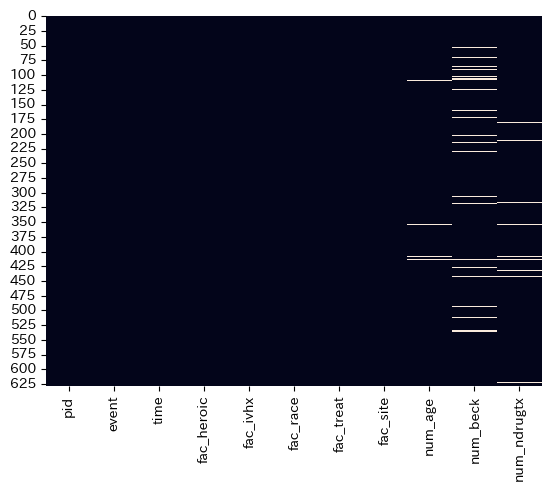

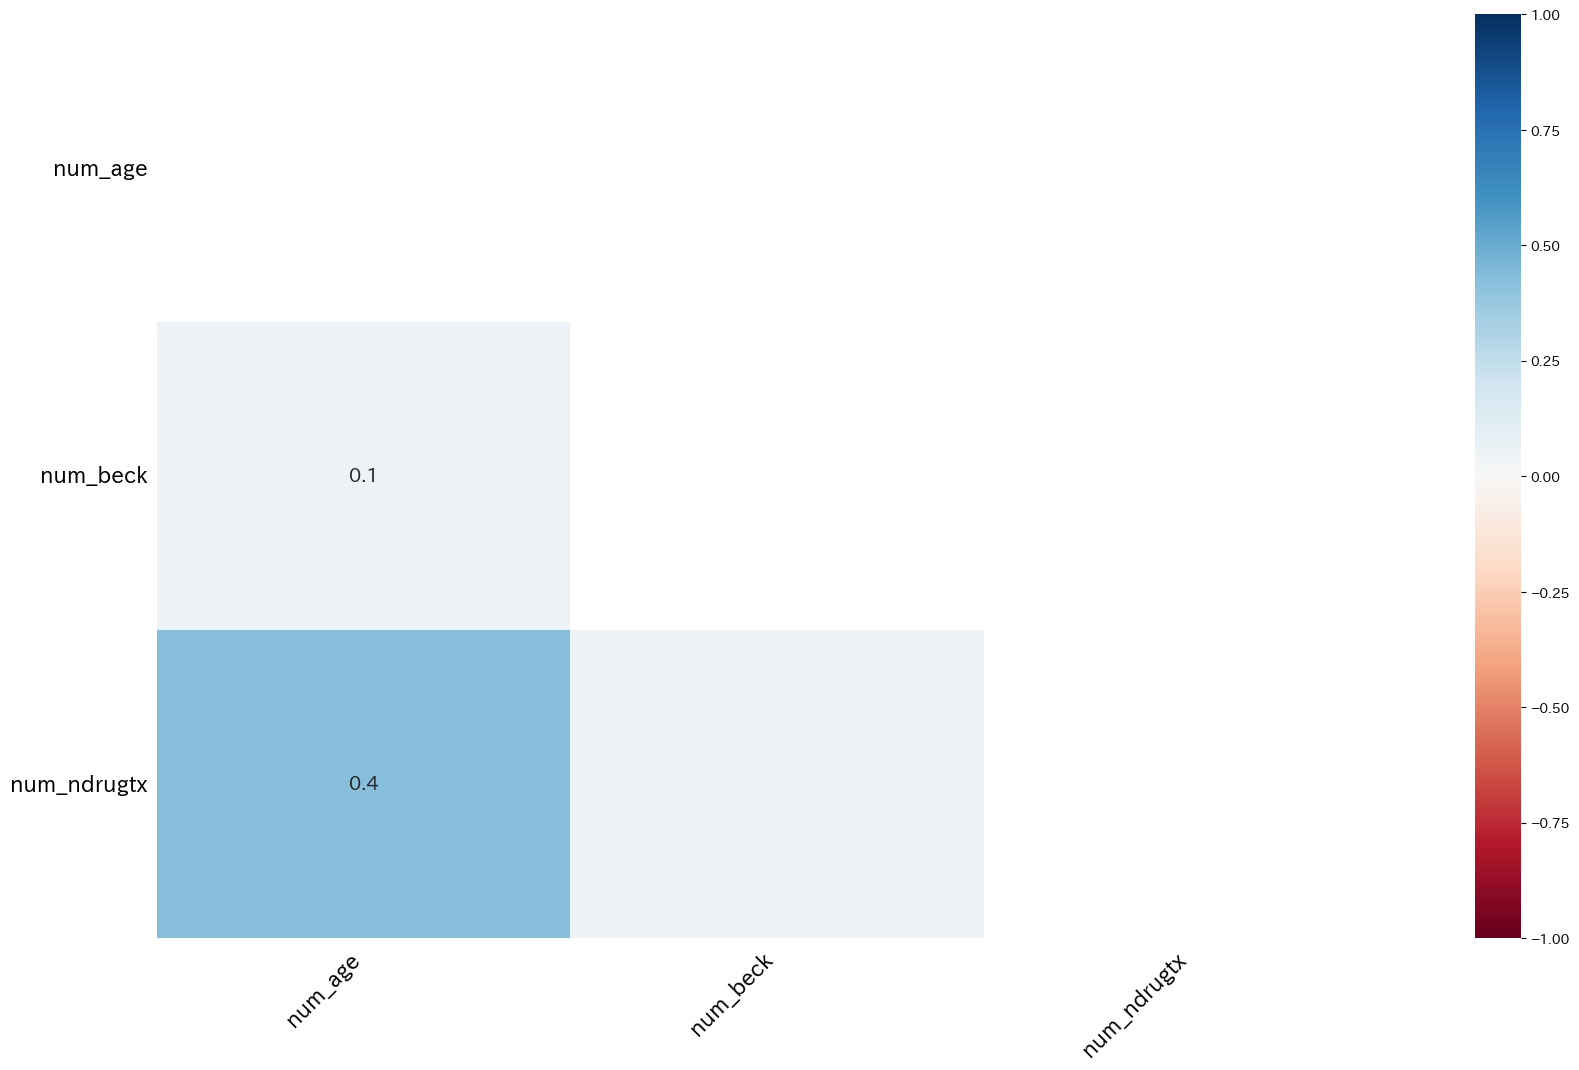

In [7]:
sns.heatmap(df.isnull(), cbar=False)
msno.heatmap(df)

### カテゴリ変数でない列の基本統計量

In [8]:
df.describe()

pid       event         time     num_age    num_beck  \
count  628.000000  628.000000   628.000000  623.000000  595.000000   
mean   313.500000    0.808917   234.703822   32.369181   17.404855   
std    181.432265    0.393468   201.701126    6.119534    9.391132   
min      0.000000    0.000000     2.000000   20.000000    0.000000   
25%    156.750000    1.000000    79.000000   27.000000   10.000000   
50%    313.500000    1.000000   166.000000   32.000000   17.000000   
75%    470.250000    1.000000   365.250000   37.000000   23.000000   
max    627.000000    1.000000  1172.000000   56.000000   54.000000   

       num_ndrugtx  
count   611.000000  
mean      4.574468  
std       5.494462  
min       0.000000  
25%       1.000000  
50%       3.000000  
75%       6.000000  
max      40.000000

## 割合の把握

- eventについて   
    0が未再使用, 1が再使用になる。
    - 未再使用等:薬物1回目の使用後に、2回目の利用が観察期間内に観察できていない個体 
    - 再使用: 薬物1回目の使用後に、2回目の利用を観察期間内に観察できた個体
- グラフからわかること
    - 再使用等が80.9%であり、ほとんどの薬物使用者が複数回の利用を行っていることがわかる。
    - 治療の有無により変化しているかは、このグラフからは検討できない

event
1    508
0    120
Name: count, dtype: int64


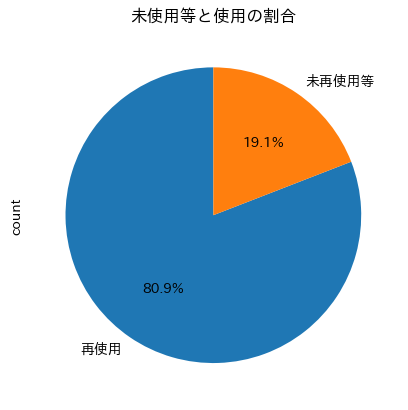

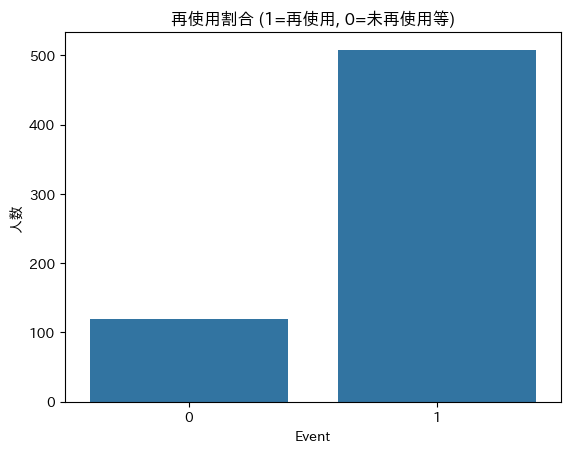

In [9]:
print(df['event'].value_counts())

# グラフ化
df['event'].value_counts().plot.pie(autopct='%1.1f%%', labels=['再使用', '未再使用等'], startangle=90)
plt.title('未使用等と使用の割合')
plt.show()

sns.countplot(x='event', data=df)
plt.title('再使用割合 (1=再使用, 0=未再使用等)')
plt.xlabel('Event')
plt.ylabel('人数')
plt.show()

## 薬物再使用と時間の関係
- 全観察対象のうち、event==1であるレコードを抽出し、
- 1回目利用直後が最も高く、徐々に減少傾向であるとうかがえる。


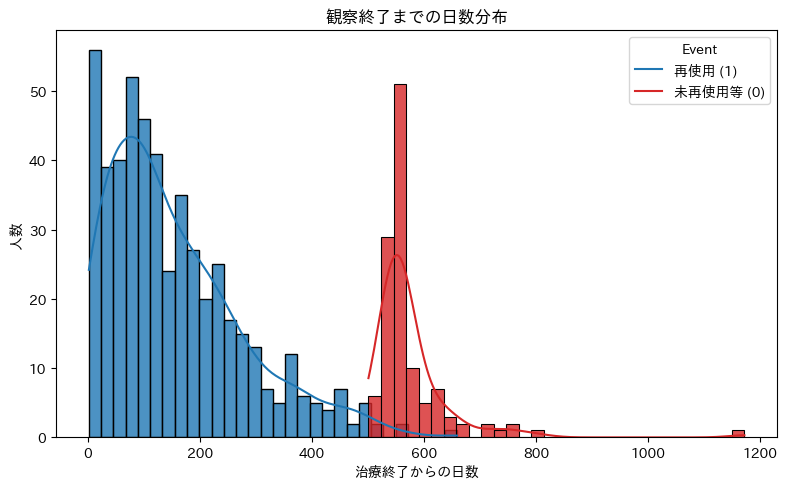

In [10]:
df_event1 = df[df["event"] == 1]    # 列名が censor の場合は df["censor"] == 1
df_event0 = df[df["event"] == 0]
plt.figure(figsize=(8, 5))
sns.histplot(
    data=df_event1,
    x="time",
    bins=30,
    kde=True,
    stat="count",
    color="tab:blue",
    edgecolor="black",
    alpha=0.8
)
sns.histplot(
    data=df_event0,
    x="time",
    bins=30,
    kde=True,
    stat="count",
    color="tab:red",
    edgecolor="black",
    alpha=0.8
)
plt.title("観察終了までの日数分布")
plt.xlabel("治療終了からの日数")
plt.legend(title='Event', labels=['再使用 (1)', '未再使用等 (0)'])
plt.ylabel("人数")
plt.tight_layout()
plt.savefig("output/plot/観察終了までの時間分布.png")
plt.show()

## 調査対象者の分布
- num_age(年齢)について   
    30代前半での調査対象者割合が多い
- num_beckについて
- num_ndrugtxについて
- timeについて
    - 打ち切りタイミングは、500日以降から順次観測されている
    - 

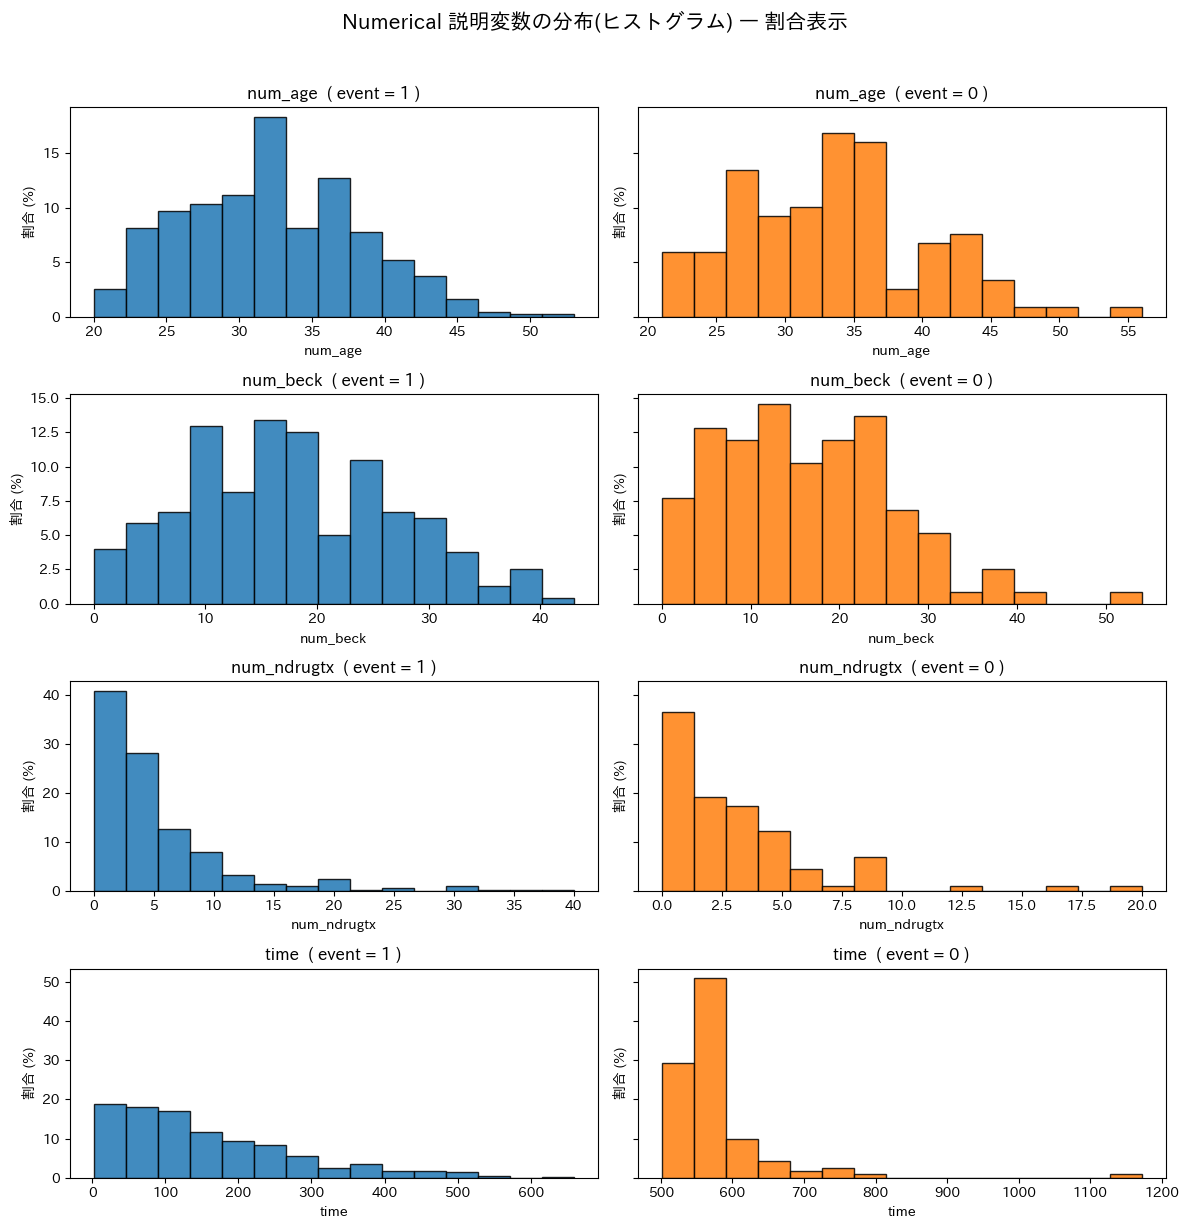

In [11]:

#^ 今回、plotの対象とするのは年齢, ベック鬱スコア, 過去の麻薬治療回数, 時間の4つである
numerical_cols = ["num_age", "num_beck", "num_ndrugtx", "time"]
event_col      = "event"

n_rows = len(numerical_cols)
fig, axes = plt.subplots(
    n_rows, 2, figsize=(12, 3 * n_rows),
    sharey="row"
)

for i, col in enumerate(numerical_cols):
    for j, ev in enumerate([1, 0]):
        ax   = axes[i, j]
        data = df.loc[df[event_col] == ev, col].dropna()
        #^ 割合表示
        weights = np.ones_like(data) / len(data) * 100

        ax.hist(
            data, bins=15, weights=weights,
            alpha=0.85, color=("tab:blue" if ev == 1 else "tab:orange"),
            edgecolor="black"
        )

        ax.set_title(f"{col}  ( {event_col} = {ev} )")
        ax.set_xlabel(col)
        ax.set_ylabel("割合 (%)")

plt.suptitle("Numerical 説明変数の分布(ヒストグラム) — 割合表示", y=1.02, fontsize=15)
plt.tight_layout()
plt.savefig("output/plot/num_説明変数の分布(ヒストグラム).png")
plt.show()

In [12]:

df_treatLONG = df[df["fac_treat"] == 1]
df_treatLONG.shape #^ 長期治療者が308人(308,11)

df_treatSHORT = df[df["fac_treat"] != 1]
df_treatSHORT.shape #^ 短期治療者が320人(320,11) 

(320, 11)

### 治療期間の長さによる、再使用までの時間推移比較
- event==1に限定しており、fac_treat==1の方が再使用までの期間が長い傾向があると伺える。
- 有意な差が生じているかは不明なため、、検定を実施する必要があると言える。

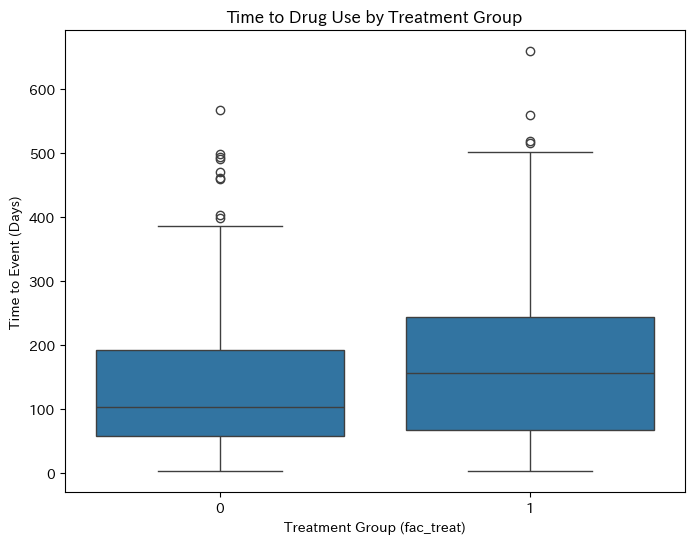

In [13]:

#^  fac_treat（0=Short, 1=Long）ごとの生存時間を可視化
plt.figure(figsize=(8,6))
sns.boxplot(x='fac_treat', y='time', data=df_event1)
plt.title('Time to Drug Use by Treatment Group')
plt.xlabel('Treatment Group (fac_treat)')
plt.ylabel('Time to Event (Days)')
plt.show()

### 静脈注射による薬物投与歴
> 1: Never(一度もない), 2: Previous(過去にあり), 3: Recent(最近)    

静脈注射は、、従来の薬物利用方法と比較すると依存度が高いと推測できる。   
また、本データからも、Neverと利用歴があるセグメントで比較すると、第三四分位点が大きく異なっているため、何らかの差があると推測できる。


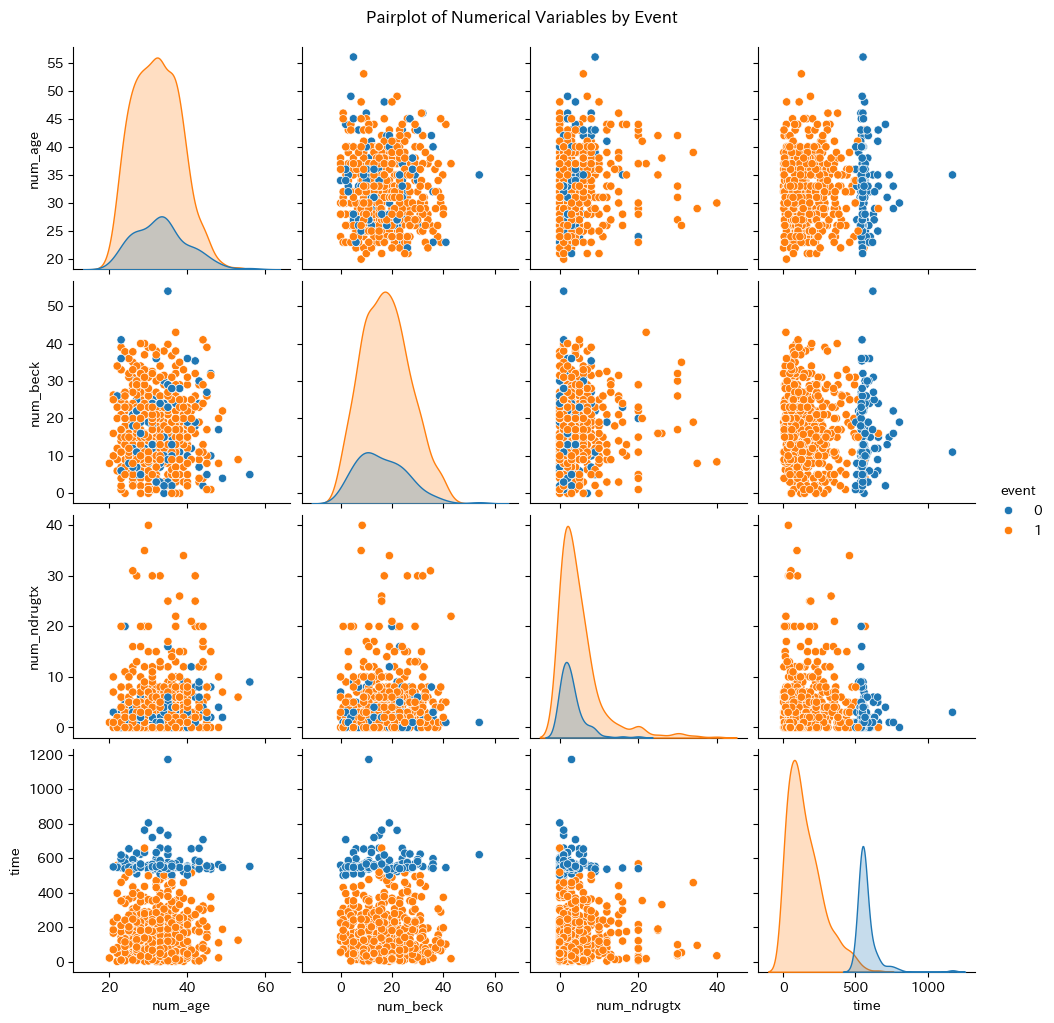

In [14]:
sns.pairplot(df, vars=['num_age', 'num_beck', 'num_ndrugtx', 'time'], hue='event')
plt.suptitle('Pairplot of Numerical Variables by Event', y=1.02)
plt.show()

In [15]:
# プロファイルレポートの作成
profile = ProfileReport(df, title="UIS Dataset EDA Report", explorative=True)

# Jupyter Notebookなら
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:00<00:00, 146934.22it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
profile.to_file("output/uis_eda_report.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# 分析

In [17]:

#^ フィッティングのため、欠損値を含むレコードの
df_model = df.dropna()
mask = df_model.isin(['missing']).any(axis=1)
df_model = df_model[~mask].reset_index(drop=True)
df_model.drop(columns=['pid'], inplace=True)

# ダミー変数化する列
cat_cols = ['fac_heroic', 'fac_ivhx', 'fac_race', 'fac_treat', 'fac_site']
df_encoded = pd.get_dummies(
    df_model,
    columns=cat_cols,
    drop_first=True
)
df_encoded = df_encoded.drop(columns=['time','event','fac_heroic_missing','fac_ivhx_missing','fac_race_missing'])
df_encoded = pd.concat([df_model['time'], df_model['event'], df_encoded], axis=1) 
df_model = df_model.apply(lambda col: pd.to_numeric(col, errors='coerce').astype(int))

df_encoded.head()

time  event  num_age  num_beck  num_ndrugtx  fac_heroic_2  fac_heroic_3  \
0   188      1     39.0       9.0          1.0         False         False   
1    26      1     33.0      34.0          8.0         False         False   
2   207      1     33.0      10.0          3.0          True         False   
3   144      1     32.0      20.0          1.0         False         False   
4   551      0     24.0       5.0          5.0          True         False   

   fac_heroic_4  fac_ivhx_2  fac_ivhx_3  fac_race_1  fac_treat_1  fac_site_1  
0          True       False        True       False         True       False  
1          True        True       False       False         True       False  
2         False       False        True       False         True       False  
3          True       False        True       False        False       False  
4         False       False       False        True         True       False

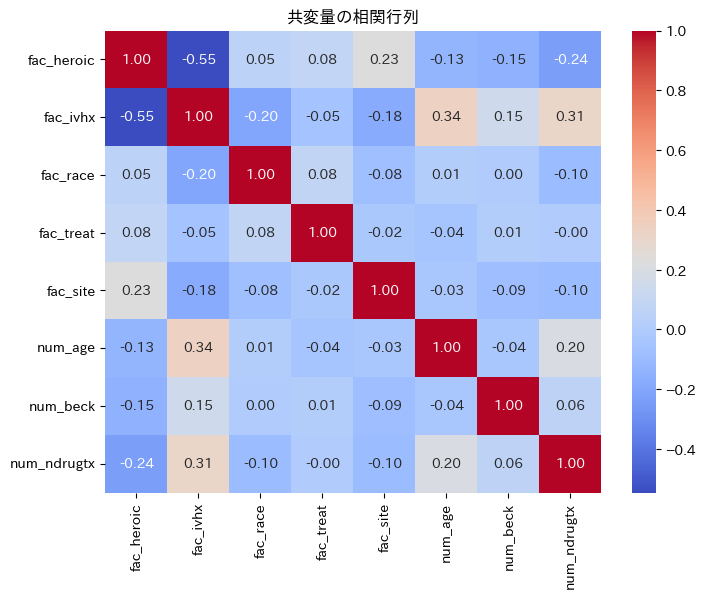

In [18]:
corr = df_model.drop(columns=['time','event']).corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("共変量の相関行列")
plt.show()

In [19]:

#^ Function to create Kaplan-Meier plots
def kaplan_meier_plot(col_name,title,
                      check=True,
                      df=df_encoded
                      ):
    kmf = KaplanMeierFitter()
    plt.figure(figsize=(10,6))
    for name, group in df.groupby(col_name):
        T = group['time']
        E = group['event']
        kmf.fit(T, event_observed=E, label=f'{col_name} {name}')
        kmf.plot_survival_function(ci_show=True)
        sf = kmf.survival_function_
        if check:
            print(f"--- fac_heroic {name} ---")
            print(sf.head(), "\n")
    plt.title(f'{title}別のKaplan-Meier曲線')
    plt.xlabel('プログラム終了からの経過日数')
    plt.ylabel('生存率(再使用していない人の割合)')
    plt.ylim(0,1)
    plt.grid(True)
    plt.legend()
    plt.savefig(f"output/plot/{title}_km_plot.png")
    plt.show()

In [20]:

#^ Function to logrank test between some groups
def logrank_test_multiple_groups(group_col,time_col="time",event_col="event", df=df_model):
    results = multivariate_logrank_test(
        df[time_col],
        df[group_col],
        df[event_col]
    )
    return results.summary

In [21]:

#^ ペアワイズログランク検定を行い、p値を行列表現で返す関数
def pairwise_logrank_matrix(df=df_model, group_col="fac_ivhx", time_col='time', event_col='event', correction=None):
    """
    複数グループのペアワイズログランク検定を実行し、
    Bonferroni 補正済みの p 値を行列表現で返す関数。

    Parameters:
    - df: pandas DataFrame
    - group_col: 群ラベルの列名
    - time_col: 生存時間の列名（デフォルト 'time'）
    - event_col: イベント発生フラグの列名（デフォルト 'event'）
    - correction: 'bonferroni' で補正、それ以外は未補正

    Returns:
    - pandas DataFrame: 行・列ともに群ラベル、要素は補正後 p 値（対角は NaN）
    """
    groups = df[group_col].dropna().unique()
    m = len(groups) * (len(groups) - 1) // 2
    p_mat = pd.DataFrame(np.nan, index=groups, columns=groups, dtype=float)
    for g1, g2 in combinations(groups, 2):
        d1 = df[df[group_col] == g1]
        d2 = df[df[group_col] == g2]
        res = logrank_test(
            d1[time_col], d2[time_col],
            event_observed_A=d1[event_col],
            event_observed_B=d2[event_col]
        )
        p_raw = res.p_value
        p_adj = min(p_raw * m, 1.0) if correction == 'bonferroni' else p_raw
        p_mat.loc[g1, g2] = p_adj
        p_mat.loc[g2, g1] = p_adj

    return p_mat

# ヘロインコカイン使用歴に関する分析

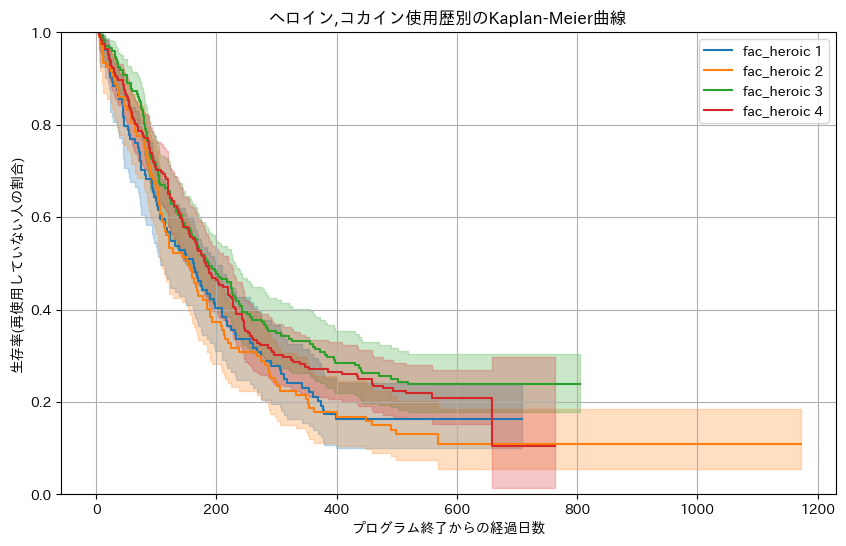

In [22]:
kaplan_meier_plot("fac_heroic", "ヘロイン,コカイン使用歴",check=False, df=df_model)

In [23]:
logrank_test_multiple_groups("fac_heroic")

test_statistic         p  -log2(p)
0        7.739107  0.051723  4.273056

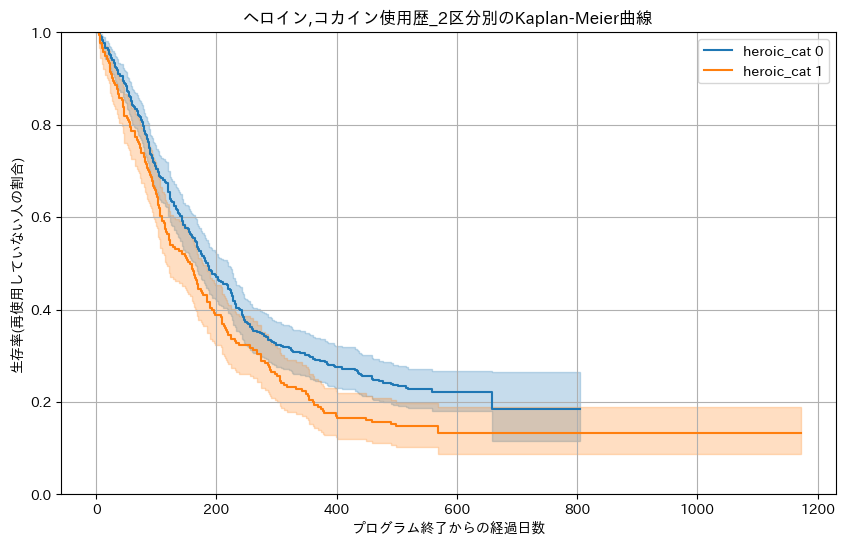

In [24]:
df_model['heroic_cat'] = df_model['fac_heroic'].isin([1, 2]).astype(int)
kaplan_meier_plot("heroic_cat", "ヘロイン,コカイン使用歴_2区分",check=False, df=df_model)

In [25]:
logrank_test_multiple_groups("heroic_cat", df=df_model)

test_statistic         p  -log2(p)
0        7.036792  0.007985  6.968457

## 静脈注射について

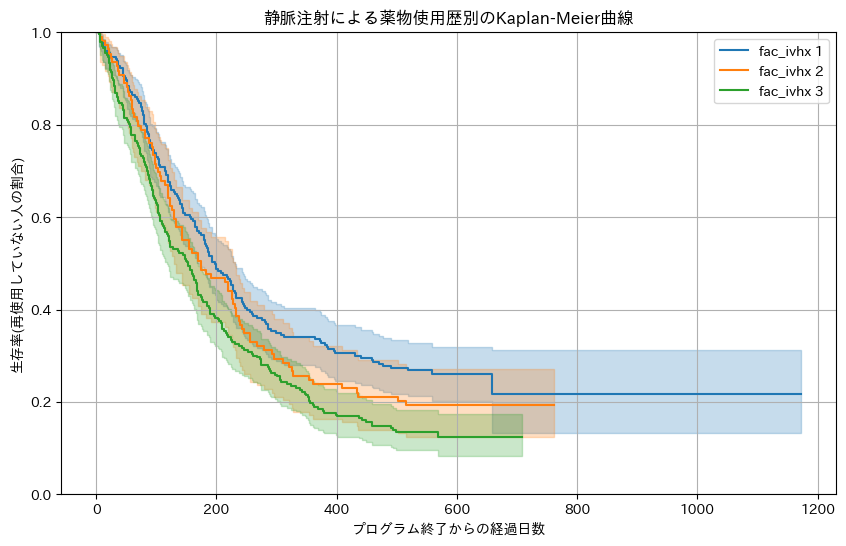

test_statistic         p  -log2(p)
0       13.723916  0.001047  9.899713

In [26]:
kaplan_meier_plot("fac_ivhx", "静脈注射による薬物使用歴",check=False, df=df_model)
logrank_test_multiple_groups("fac_ivhx", df=df_model)

In [27]:
pairwise_logrank_matrix(df=df_model, 
                        group_col='fac_ivhx', 
                        time_col='time', 
                        event_col='event',
                        correction='bonferroni'
                        )

3         2         1
3       NaN  0.327842  0.000681
2  0.327842       NaN  0.535419
1  0.000681  0.535419       NaN

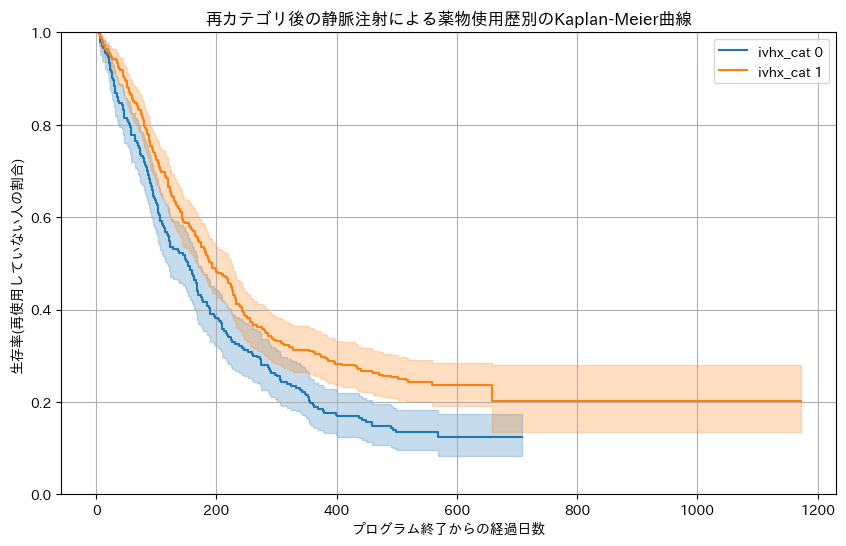

test_statistic         p   -log2(p)
0       12.102677  0.000503  10.955735

In [28]:
df_model["ivhx_cat"] = df_model["fac_ivhx"].isin([1, 2]).astype(int)
kaplan_meier_plot("ivhx_cat", "再カテゴリ後の静脈注射による薬物使用歴",check=False, df=df_model)
logrank_test_multiple_groups("ivhx_cat", df=df_model)


## fac_race 白人か否か

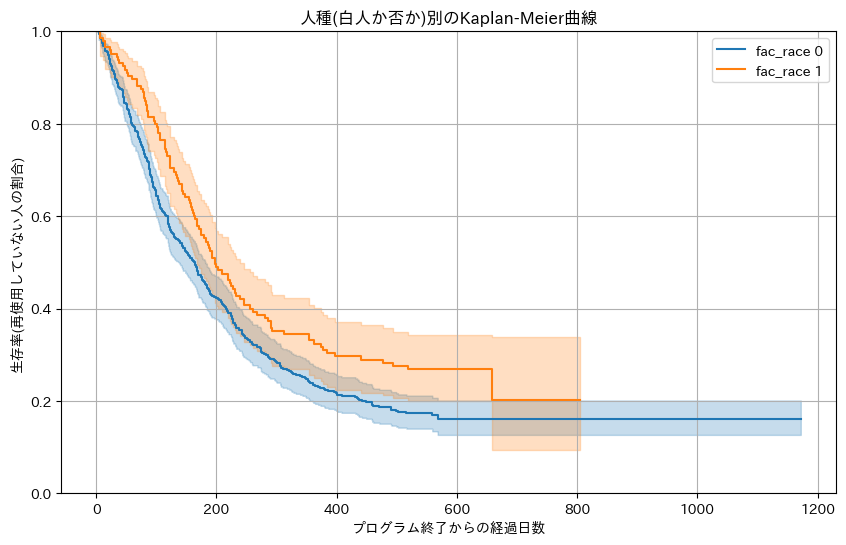

test_statistic         p  -log2(p)
0        7.431122  0.006411  7.285339

In [35]:
kaplan_meier_plot("fac_race", "人種(白人か否か)",check=False, df=df_model)
logrank_test_multiple_groups("fac_race", df=df_model)

## fac_treat
- 治療プロジェクトの種類

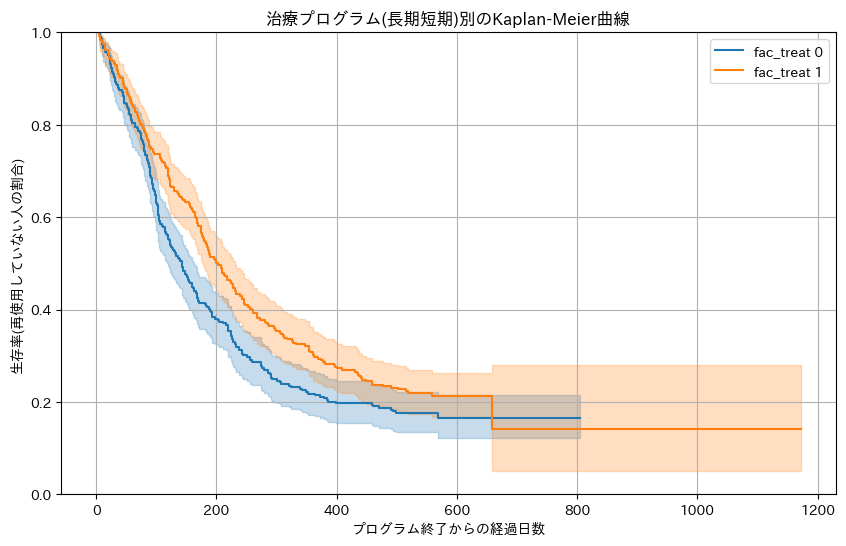

test_statistic         p  -log2(p)
0        6.528395  0.010617  6.557539

In [37]:
kaplan_meier_plot("fac_treat", "治療プログラム(長期短期)",check=False, df=df_model)
logrank_test_multiple_groups("fac_treat", df=df_model)

## fac_site(治療施設種別)

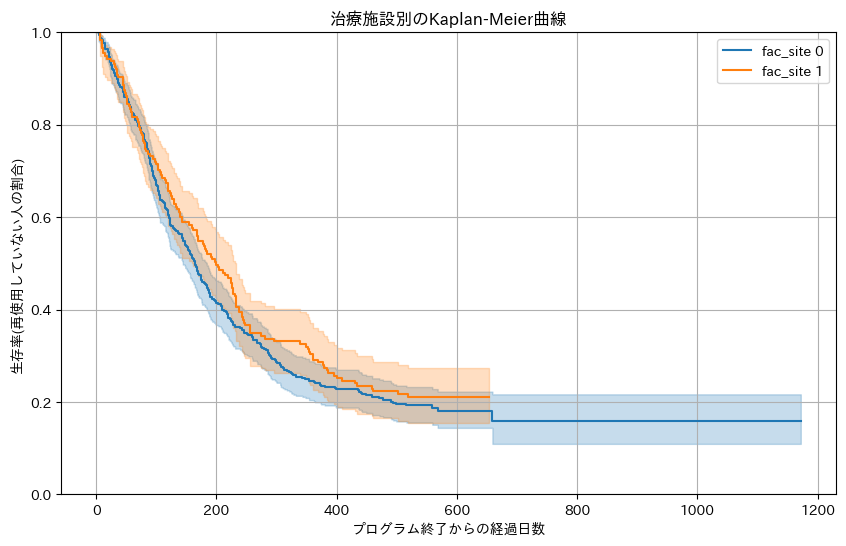

test_statistic         p  -log2(p)
0        1.091169  0.296212  1.755296

In [38]:
kaplan_meier_plot("fac_site", "治療施設",check=False, df=df_model)
logrank_test_multiple_groups("fac_site", df=df_model)

## fac_treat * fac_site


In [49]:
df_model['treat_site'] = df_model['fac_treat'].astype(str) + '_' + df_model['fac_site'].astype(str)

mapping = {
    '0_0': 'Short_A',  # 短期プログラム × サイトA
    '0_1': 'Short_B',  # 短期プログラム × サイトB
    '1_0': 'Long_A',   # 長期プログラム × サイトA
    '1_1': 'Long_B'    # 長期プログラム × サイトB
}
df_model['treat_site'] = df_model['treat_site'].map(mapping).astype('category')


/var/folders/wb/sqvg1jfx4qvbgf2ndb8gt5300000gn/T/ipykernel_14688/2736816905.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in df.groupby(col_name):


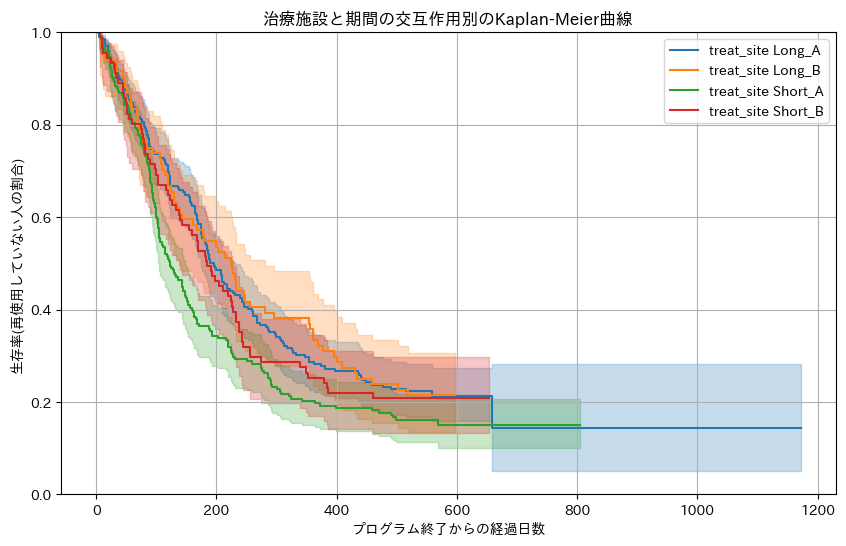

test_statistic         p  -log2(p)
0        9.089898  0.028119    5.1523

In [51]:
kaplan_meier_plot("treat_site", "治療施設と期間の交互作用",check=False, df=df_model)
logrank_test_multiple_groups("treat_site", df=df_model)

In [52]:
pairwise_logrank_matrix(
    df=df_model, 
    group_col='treat_site', 
    time_col='time', 
    event_col='event',
    correction='bonferroni'
)

Long_A   Short_A   Short_B    Long_B
Long_A        NaN  0.039431  1.000000  1.000000
Short_A  0.039431       NaN  0.808129  0.193267
Short_B  1.000000  0.808129       NaN  1.000000
Long_B   1.000000  0.193267  1.000000       NaN

# Cox回帰モデル

In [30]:
cph = CoxPHFitter()
cph.fit(df_model, 'time','event', formula="fac_ivhx")  # 1,2,3 の数値をそのまま入れる
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 575 total observations, 111 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 575
number of events observed = 464
   partial log-likelihood = -2656.33
         time fit was run = 2025-07-16 16:07:06 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
fac_ivhx   0.19      1.21      0.05            0.09            0.29                1.09                1.34

           cmp to    z      p  -log2(p)
covariate                              
fac_ivhx     0.00 3.68 <0.005     12.07
---
Concordance = 0.55
Partial AIC = 5314.66
log-likelihood ratio test = 13.64 on 1 df
-log2(p) of ll-ratio test = 12.14

In [31]:
cph = CoxPHFitter()
cph.fit(
    df_encoded,
    duration_col='time',
    event_col='event'
)
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 575 total observations, 111 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 575
number of events observed = 464
   partial log-likelihood = -2639.10
         time fit was run = 2025-07-16 16:07:06 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
num_age      -0.03      0.97      0.01           -0.04           -0.01                0.96                0.99
num_beck      0.01      1.01      0.00           -0.00            0.02                1.00                1.02
num_ndrugtx   0.03      1.03      0.01            0.01            0.04                1.01                1.05
fac_heroic_2  0.07      1.07      0.15           -0.23            0.36                0.80                1.43
fac_heroic_3 -0.09      0.91      0.17           -0.42            0.23                0.66                1.26
fac_heroic_4  0.03      1.03      0.16           -0.29            0.34                0.75                1.41
fac_ivhx_2    0.17      1.19      0.14           -0.10            0.45                0.91                1.56
fac_ivhx_3    0.28      1.32      0.15           -0.01            0.57                0.99                1.77
fac_race_1   -0.20      0.82      0.12           -0.43            0.03                0.65                1.03
fac_treat_1  -0.24      0.79      0.09           -0.43           -0.06                0.65                0.95
fac_site_1   -0.10      0.90      0.11           -0.32            0.11                0.73                1.12

              cmp to     z      p  -log2(p)
covariate                                  
num_age         0.00 -3.54 <0.005     11.28
num_beck        0.00  1.68   0.09      3.43
num_ndrugtx     0.00  3.42 <0.005     10.66
fac_heroic_2    0.00  0.44   0.66      0.59
fac_heroic_3    0.00 -0.57   0.57      0.81
fac_heroic_4    0.00  0.17   0.86      0.21
fac_ivhx_2      0.00  1.26   0.21      2.27
fac_ivhx_3      0.00  1.91   0.06      4.16
fac_race_1      0.00 -1.74   0.08      3.61
fac_treat_1     0.00 -2.55   0.01      6.53
fac_site_1      0.00 -0.94   0.35      1.53
---
Concordance = 0.60
Partial AIC = 5300.20
log-likelihood ratio test = 48.10 on 11 df
-log2(p) of ll-ratio test = 19.48


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


[[<Axes: xlabel='rank-transformed time\n(p=0.5826)'>,
  <Axes: xlabel='km-transformed time\n(p=0.5899)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0928)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0931)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.6315)'>,
  <Axes: xlabel='km-transformed time\n(p=0.6323)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.7118)'>,
  <Axes: xlabel='km-transformed time\n(p=0.7087)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.9323)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9382)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.8014)'>,
  <Axes: xlabel='km-transformed time\n(p=0.8026)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.6294)'>,
  <Axes: xlabel='km-transformed time\n(p=0.6261)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.9031)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9064)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.2412)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2441)'>],
 [<Axes: xlabel='rank-transformed tim

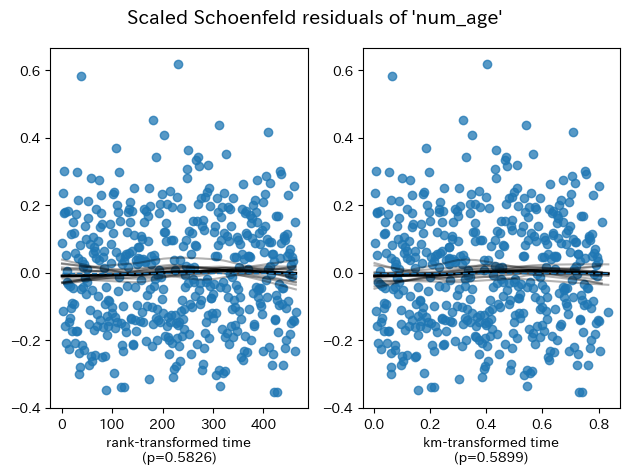

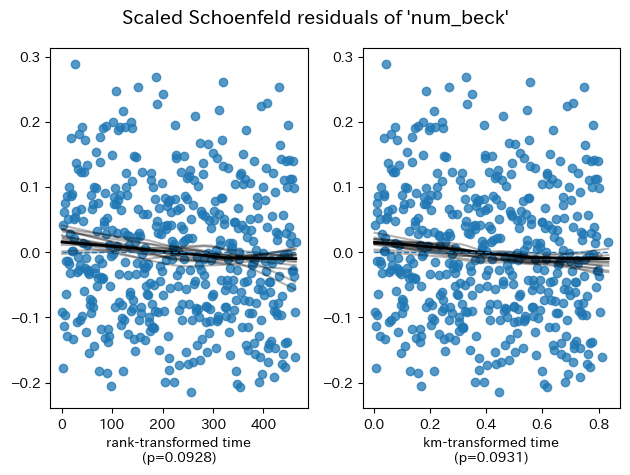

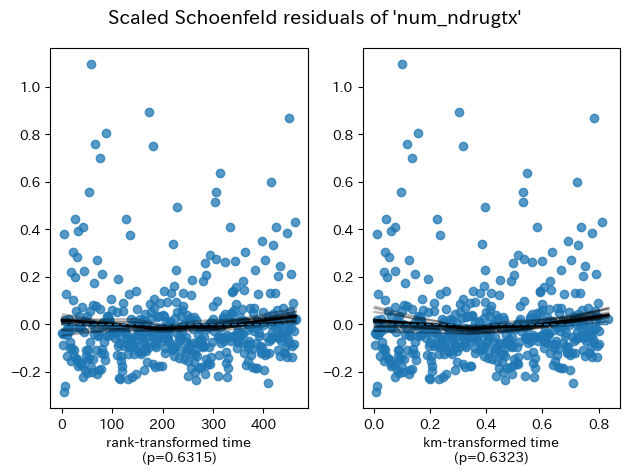

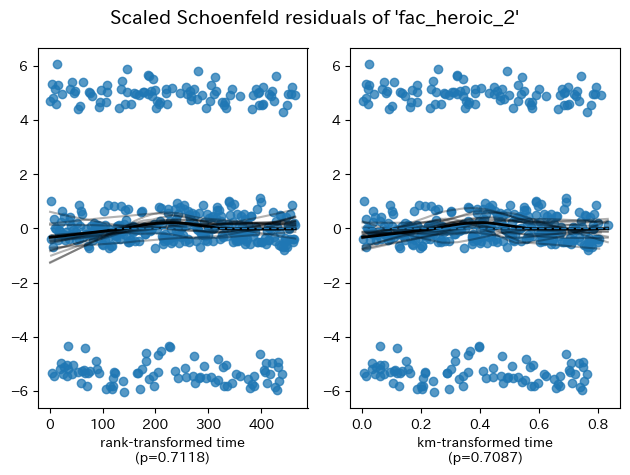

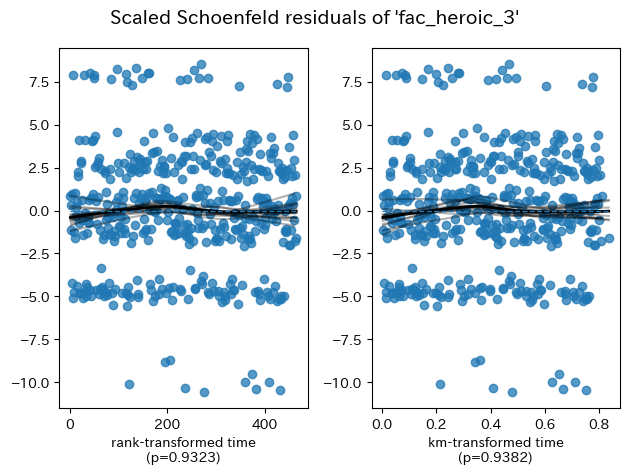

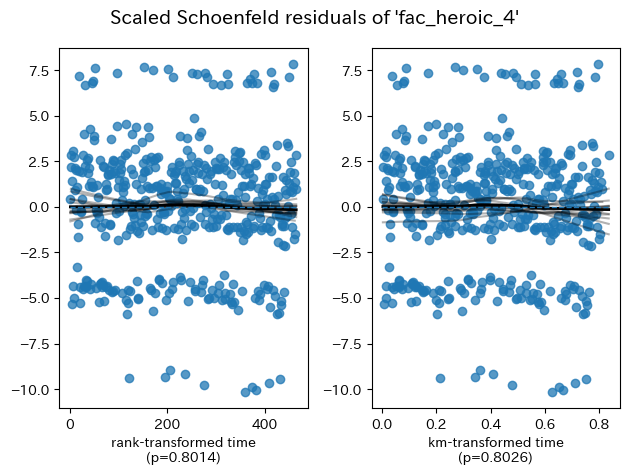

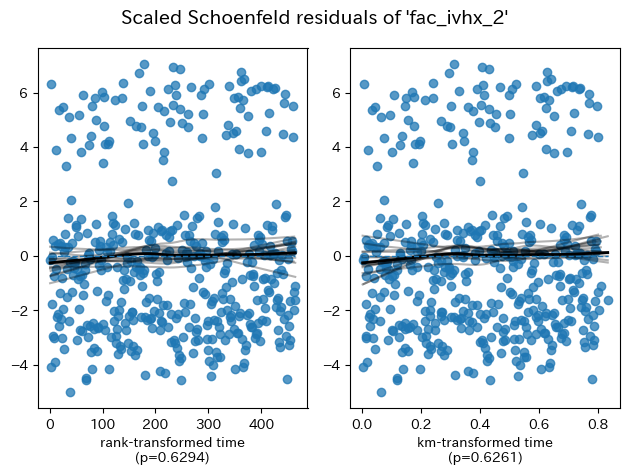

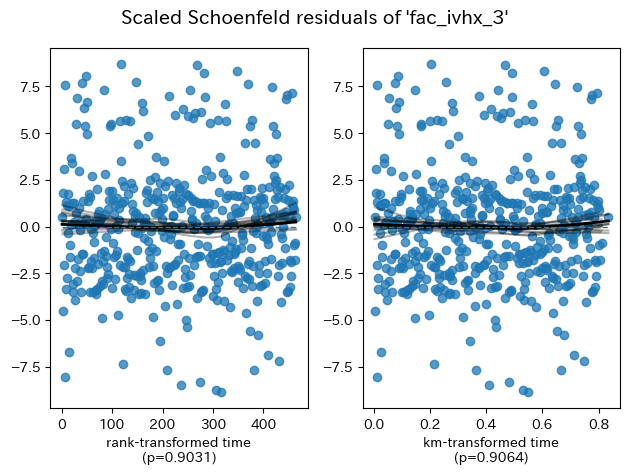

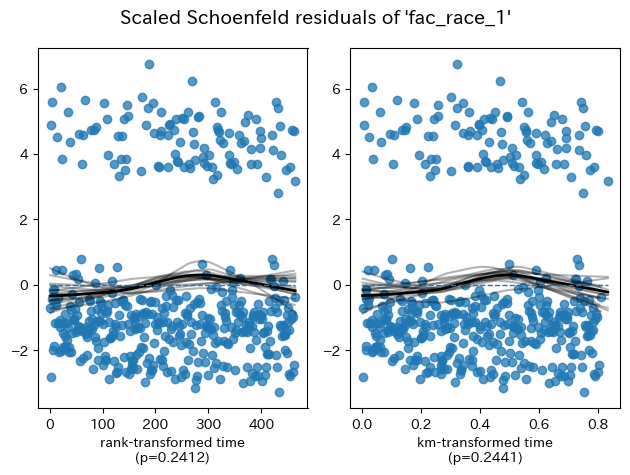

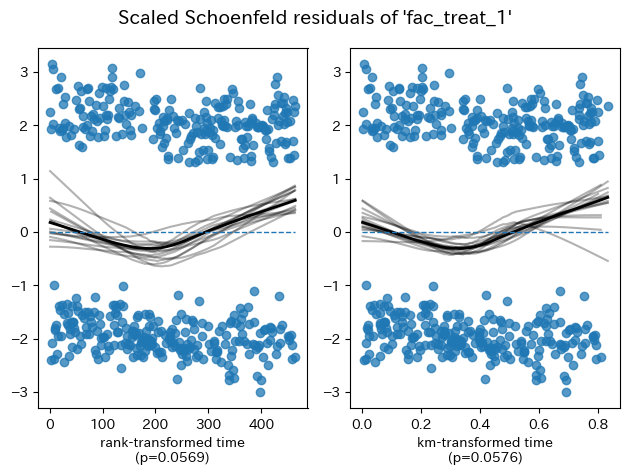

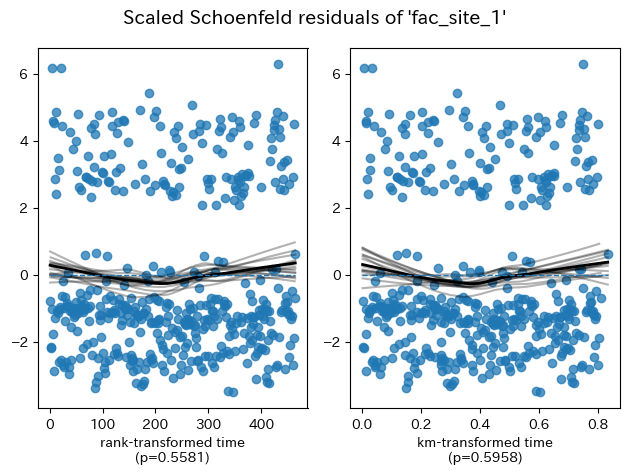

In [32]:
# PH 仮定のチェック
cph.check_assumptions(df_encoded, p_value_threshold=0.05, show_plots=True)

- Treatの違いによる、生存関数の違いを把握する
- 横軸が時間の流れ
- 縦軸が、生存割合

# ログランク検定
- 有意の差があるかどうかの検定 -> どのくらいの差があるかは判定できない

In [33]:
result = statistics.logrank_test(
    df.loc[df["fac_treat"]==0, "time"],
    df.loc[df["fac_treat"]==1, "time"],
    event_observed_A=df.loc[df["fac_treat"]==0, "event"],
    event_observed_B=df.loc[df["fac_treat"]==1, "event"],

)

print("=== Log-rank Test: Short vs Long ===")
print(f"Test statistic (χ²) = {result.test_statistic:.3f}")
print(f"p-value              = {result.p_value:.5f}")

=== Log-rank Test: Short vs Long ===
Test statistic (χ²) = 6.798
p-value              = 0.00913


# Schoenfeld残差

In [34]:
cph = CoxPHFitter()
cph.fit(df, duration_col='time', event_col='event')
cph.check_assumptions(df, p_value_threshold=0.05, show_plots=True)

ValueError: Cannot cast object dtype to float64

# Cox回帰(比例ハザードモデル)による、影響度評価
### 特徴
- 何倍長生きしやすいか
- 発生率の割合(比)を求められる

### 条件
- 比例ハザードモデルを利用している(時間によらず一定である)
    - 曲線がクロスすることはない
    - 曲線の間隔の比は一定
    -> 検定は、ログランク検定

### 問題
- 競合リスク
    - 色々な問題が存在することで、当該イベントについての観察ができなくなる場合がある


# 比例ハザード性がない場合の推定

In [ ]:
df_dropedna = df.copy().dropna()
cph = CoxPHFitter()
cph.fit(
    df_dropedna[["time", "event", "fac_treat"]],
    duration_col="time",
    event_col="event"
)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 575 total observations, 111 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 575
number of events observed = 464
   partial log-likelihood = -2659.90
         time fit was run = 2025-07-15 15:07:13 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
fac_treat -0.24      0.79      0.09           -0.42           -0.06                0.66                0.95

           cmp to     z    p  -log2(p)
covariate                             
fac_treat    0.00 -2.55 0.01      6.54
---
Concordance = 0.54
Partial AIC = 5321.79
log-likelihood ratio test = 6.51 on 1 df
-log2(p) of ll-ratio test = 6.54

In [ ]:
df2 = df.copy()

# ―― fac_ivhx: 1=Never, 2=Previous, 3=Recent, missing→1 に統合
df2["fac_ivhx"] = df2["fac_ivhx"].replace("missing", 1)

# ↓ ここでは dropna しない（time, event は欠損なし想定）
num_cols = ["num_age", "num_beck", "num_ndrugtx"]
df2[num_cols] = (
    df2[num_cols]     # 欠損があれば 0 埋め or 平均埋めでも OK
    .fillna(df2[num_cols].mean())
    .pipe(lambda x: (x - x.mean()) / x.std(ddof=0))   # 標準化
)

formula = (
    "fac_treat + num_age + num_beck + num_ndrugtx + "
    "C(fac_ivhx)"         # ← Treatment() 指定を外す
)
from lifelines import CoxPHFitter
cph = CoxPHFitter(penalizer=1.0, l1_ratio=0.3)
cph.fit(df2, "time", "event", formula=formula)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 575 total observations, 111 right-censored observations>
             duration col = 'time'
                event col = 'event'
                penalizer = 1.0
                 l1 ratio = 0.3
      baseline estimation = breslow
   number of observations = 575
number of events observed = 464
   partial log-likelihood = -2663.15
         time fit was run = 2025-07-15 15:07:13 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
fac_treat          -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
num_age            -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
num_beck            0.00      1.00      0.00           -0.00            0.00                1.00                1.00
num_ndrugtx         0.00      1.00      0.00           -0.00            0.00                1.00                1.00
C(fac_ivhx)[T.2.0] -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
C(fac_ivhx)[T.3.0]  0.00      1.00      0.00           -0.00            0.00                1.00                1.00

                    cmp to     z    p  -log2(p)
covariate                                      
fac_treat             0.00 -0.00 1.00      0.00
num_age               0.00 -0.00 1.00      0.00
num_beck              0.00  0.00 1.00      0.00
num_ndrugtx           0.00  0.00 1.00      0.00
C(fac_ivhx)[T.2.0]    0.00 -0.00 1.00      0.00
C(fac_ivhx)[T.3.0]    0.00  0.00 1.00      0.00
---
Concordance = 0.58
Partial AIC = 5338.30
log-likelihood ratio test = -0.00 on 6 df
-log2(p) of ll-ratio test = -0.00

# まとめ